<img src="JFM-notebooks-logo.jpg" style="max-width:100%" />

### Imports

In [3]:
import sys, os
os.environ['NOWARNINGS'] = '1'
sys.path.append(os.path.join('Code'))
from load_data import load_data
from postprocessing.plotting import *
plotting_defaults()
plt.rcParams['figure.dpi'] = 150 # to adjust display size in notebook
ref, refsim, transient, varsim_list, enssim = load_data('Data')
textwidth = 5.31445

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import LogLocator
from postprocessing.plotting import *
from postprocessing.superposition import *

### Generate figure

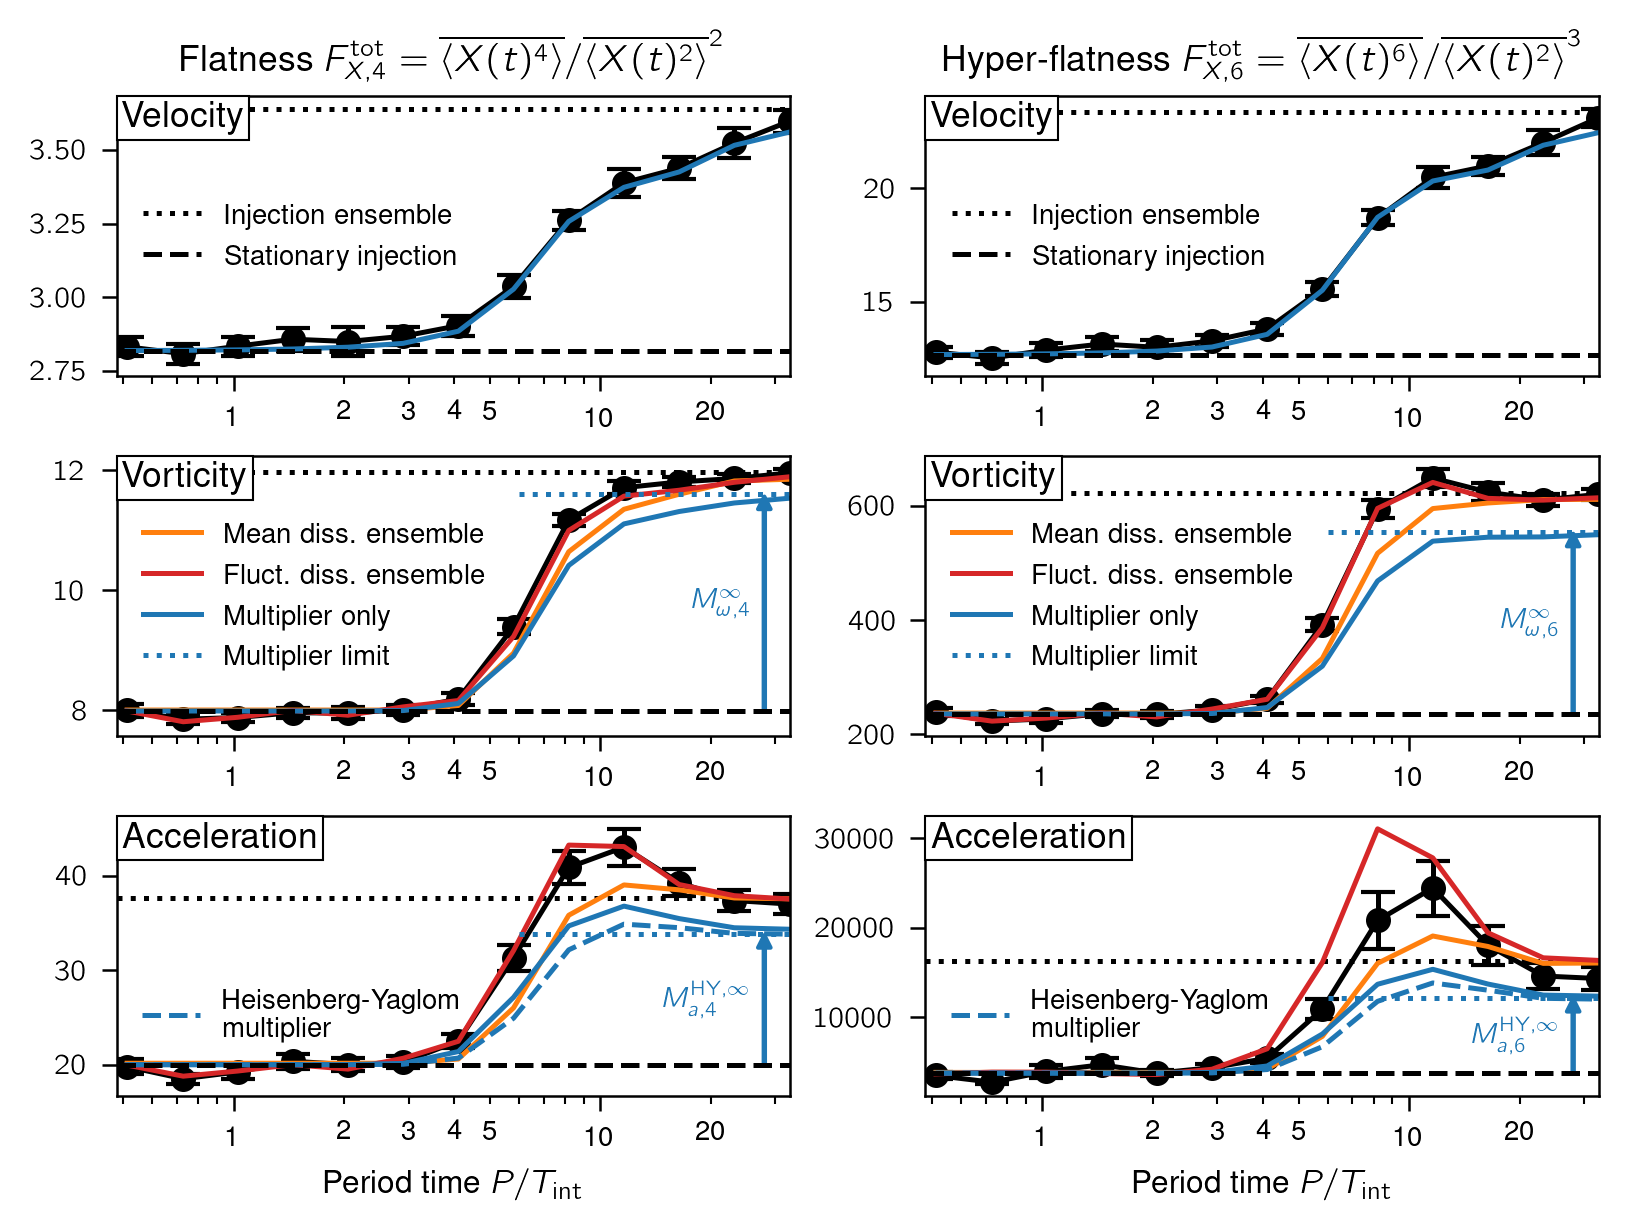

In [5]:
# set up figure
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(textwidth, 0.75*textwidth))
axs[0, 0].set_title(r'Flatness $F^\mathrm{tot}_{X,4} = \overline{\langle X(t)^4 \rangle}/\overline{\langle X(t)^2 \rangle}^2$')
axs[0, 1].set_title(r'Hyper-flatness $F^\mathrm{tot}_{X,6} = \overline{\langle X(t)^6 \rangle}/\overline{\langle X(t)^2 \rangle}^3$')

nbins = 256
if not enssim is None:
    ## compute ensemble weights
    injrate_weights = compute_injrate_weights(enssim, varsim_list[0])
    diss_weights = compute_diss_weights(enssim,
                                        varsim_list,
                                        transient,
                                        tbinno = nbins,
                                        tbinminsize = ref.tauK/2)
    # compute 2D weights `fluctdiss_weights` for fluctuating dissipation ensemble
    # axes of `fluctdiss_weights` are (varsim_id, ensemble_member, rescale_bin)
    dissmom2_bins, rescale_bins, fluctdiss_weights = \
        compute_fluctdiss_weights(enssim,
                                varsim_list,
                                transient,
                                period_bins = nbins,
                                tbinminsize = ref.tauK/2)
    rescale_vals = (rescale_bins[1:] + rescale_bins[:-1])/2

## iterate over flatness and hyperflatness
for colkey, order in enumerate([4, 6]):
    # iterate over quantities
    for qkey, quantity in enumerate(['vel', 'vort', 'acc']):

        # set up axes
        ca = axs[qkey, colkey]
        plt.sca(ca)
        if quantity == 'vel':
            title = 'Velocity'
        elif quantity == 'vort':
            title = 'Vorticity'
        else:
            title = 'Acceleration'
        at = AnchoredText(
            title,
            frameon=True, loc='upper left', borderpad=0., pad=0.15)
        at.patch.set(lw=0.5, edgecolor='black')
        plt.gca().add_artist(at)

        # collect period times
        vperiod = np.array([varsim.get_period() for varsim in varsim_list])

        # compute total flatness and plot it
        vflatness = []
        vflatness_err = []
        for vkey, varsim in enumerate(varsim_list):
            flatness, flatness_err = varsim.total_flatness(quantity, transient, order=order)
            vflatness.append(flatness)
            vflatness_err.append(flatness_err)
        plt.errorbar(vperiod/ref.Tint, vflatness, yerr=vflatness_err,
                    color='black', marker='o', capsize=4, zorder=-10)

        if not enssim is None:
            # moments of the ensemble simulations
            moments = enssim.get_time_averaged_ensemble_stat(f'moments/{quantity}', transient)

            # injection rate ensemble
            injflatness = np.sum(injrate_weights*moments[:, order]) \
                        / np.sum(injrate_weights*moments[:, 2])**(order//2)
            plt.axhline(injflatness, label='Injection ensemble' if quantity == 'vel' else None,
                color='black', ls=':')

            # mean dissipation ensemble
            if not quantity == 'vel':
                dissflatness = np.sum(diss_weights*moments[:, order], axis=1) \
                            / np.sum(diss_weights*moments[:, 2], axis=1)**(order//2)
                plt.plot(vperiod/ref.Tint, dissflatness, label='Mean diss. ensemble' if quantity =='vort' else None,
                        color=f'C1')

            # fluctuating dissipation ensemble
            # diss ~ L^2/T^3, nu ~ L^2/T
            # nu const => L^2 ~ T
            # => diss ~ 1/T^2 => T ~ 1/diss^(1/2), L ~ 1/diss^(1/4)
            if not quantity == 'vel':
                time_rescale = 1/rescale_vals**(1/2)
                space_rescale = 1/rescale_vals**(1/4)
                if quantity == 'vel':
                    total_rescale = space_rescale/time_rescale
                elif quantity == 'vort':
                    total_rescale = 1/time_rescale
                elif quantity == 'acc':
                    total_rescale = space_rescale/time_rescale**2
                fluctdissflatness = \
                    np.sum(fluctdiss_weights*moments[:, np.newaxis, order]*total_rescale**order, axis=(1,2)) \
                / np.sum(fluctdiss_weights*moments[:, np.newaxis, 2]*total_rescale**2, axis=(1,2))**(order//2)
                plt.plot(vperiod/ref.Tint, fluctdissflatness,
                        label='Fluct. diss. ensemble' if quantity == 'vort' else None,
                        color=f'C3')

        # multipliers
        refmoments = np.mean(refsim.statistics[f'moments/{quantity}'], axis=0)
        refflatness = refmoments[order] / refmoments[2]**(order//2)
        multiplier = [] # exact multiplier
        multiplier_hy = [] # multiplier estimated by Heisenberg-Yaglom
        for vkey, varsim in enumerate(varsim_list):
            t_bins = varsim.get_tbins(nbins, minsize=ref.tauK/2)
            # periodically averaged dissipation rate
            dissseries = varsim.periodic_average(varsim.statistics['diss(t)'], t_bins, transient)
            # periodically averaged variance of the quantity
            varianceseries = varsim.periodic_average(varsim.statistics[f'moments/{quantity}'][:,2], t_bins, transient)
            if quantity == 'acc':
                multiplier_hy.append(
                    np.mean(dissseries**(3*order/4)) / np.mean(dissseries**(3/2))**(order//2))
            multiplier.append(np.mean(varianceseries**(order//2))/np.mean(varianceseries)**(order//2))
        if quantity == 'acc':
            plt.plot(vperiod/ref.Tint, refflatness*np.array(multiplier_hy),
                label='Heisenberg-Yaglom\n multiplier',
                color = 'C0', ls='--')
        plt.plot(vperiod/ref.Tint, refflatness*np.array(multiplier),
                label='Multiplier only' if quantity =='vort' else None,
                color = 'C0')

        # analytically computed multiplier limits
        if quantity == 'vort':
            if order == 4:
                multlimit = 1 + 0.95**2/2
            elif order == 6:
                multlimit = 1 + 3*0.95**2/2
        elif quantity == 'acc':
            if order == 4:
                multlimit = 1.69315
            elif order == 6:
                multlimit = 3.23371
        if quantity == 'acc' or quantity == 'vort':
            plt.hlines(refflatness*multlimit, 6, 100,
                        color='tab:blue', ls=':', label='Multiplier limit' if quantity == 'vort' else None)
            plt.annotate('', xy=(28, refflatness*multlimit), xytext=(28, refflatness),
                        arrowprops=dict(color='tab:blue', shrink=0.01, width=0.3, headwidth=3, headlength=3),
                        horizontalalignment='left',
                        verticalalignment='bottom')
            plt.text(26, refflatness*(1+multlimit)/2,
                     r'$M_{{{},{}}}^{{{}}}$'.format(
                         r'\omega' if quantity == 'vort' else 'a', order,
                         r'\infty' if quantity == 'vort' else r'\mathrm{HY},\infty'
                     ), color='tab:blue',
                    ha='right', va='center', fontdict={'size':7},)

        # reference simulation
        plt.axhline(refflatness, color='black', ls='--', zorder=5,
            label = 'Stationary injection' if quantity =='vel' else None)       

        # range and labels
        if qkey == 2:
            plt.xlabel(r'Period time $P/T_\mathrm{int}$')
        plt.xscale('log')
        ca.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        plt.xticks([1, 10], ['1', '10'])
        minor_locator = LogLocator(subs=np.arange(2,10))
        ca.xaxis.set_minor_locator(minor_locator)
        ca.xaxis.set_minor_formatter(lambda x, pos: str(int(x)) if
                                    x in [2., 3., 4., 5., 20.] else '')
        if quantity == 'acc':
            plt.legend(frameon=False, loc=(0.02, 0.15))
        else:
            plt.legend(frameon=False, loc='center left')
        plt.xlim(0.48, 33);